<h1 id="punto-1">Punto 1</h1>

## Punto 1.1 <a id="punto-1-1"></a>

In [38]:
import numpy as np
import pandas as pd


df = pd.read_csv(r"../data/raw/casas_dev.csv") 

df.sample(5, random_state=42)


,area,area_units,is_house,has_pool,age,price,lat,lon,rooms
70,872.0,sqft,0,0,11.0,630.0,40.718433,-74.008699,2.0
827,1076.0,sqft,0,0,7.0,772.0,40.707037,-73.998823,3.0
231,137.0,m2,0,0,10.0,214.0,-34.550223,-58.391268,4.0
588,775.0,sqft,1,1,10.0,751.0,40.726223,-74.043929,2.0
39,154.0,m2,1,0,16.0,273.0,-34.563525,-58.347365,4.0


In [39]:

df.describe(include='all')


,area,area_units,is_house,has_pool,age,price,lat,lon,rooms
count,900.000000,900,900.000000,900.000000,770.000000,900.000000,900.000000,900.000000,828.000000
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,m2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,463,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,533.598889,NaN,0.418889,0.144444,10.212987,466.197778,1.966225,-65.967203,2.737923
std,502.318230,NaN,0.493651,0.351735,4.773010,347.122903,37.661269,7.813671,0.948574
min,40.000000,NaN,0.000000,0.000000,1.000000,65.000000,-34.686302,-74.058238,1.000000
25%,93.000000,NaN,0.000000,0.000000,6.250000,178.750000,-34.605803,-74.005566,2.000000
50%,164.500000,NaN,0.000000,0.000000,11.000000,323.500000,-34.529704,-58.459293,3.000000
75%,980.000000,NaN,1.000000,0.000000,14.000000,712.500000,40.709819,-58.379873,3.000000


Algo que es particular resaltar es que la feature ```area_units``` no tiene sentido que se mantenga. Podemos realizar una conversión y eliminar está feature.

Convertimos la feature ```sqft``` a ```m2``` y eliminamos la columna ```area_units```

In [40]:
df.loc[df['area_units'] == 'sqft', 'area'] = df['area'] * 0.092903
df.loc[df['area_units'] == 'sqft', 'area_units'] = 'm2'

df = df.drop('area_units', axis=1)

df.describe(include='all')

,area,is_house,has_pool,age,price,lat,lon,rooms
count,900.000000,900.000000,900.000000,770.000000,900.000000,900.000000,900.000000,828.000000
mean,94.794747,0.418889,0.144444,10.212987,466.197778,1.966225,-65.967203,2.737923
std,30.220560,0.493651,0.351735,4.773010,347.122903,37.661269,7.813671,0.948574
min,40.000000,0.000000,0.000000,1.000000,65.000000,-34.686302,-74.058238,1.000000
25%,74.000000,0.000000,0.000000,6.250000,178.750000,-34.605803,-74.005566,2.000000
50%,92.995903,0.000000,0.000000,11.000000,323.500000,-34.529704,-58.459293,3.000000
75%,111.264314,1.000000,0.000000,14.000000,712.500000,40.709819,-58.379873,3.000000
max,237.000000,1.000000,1.000000,20.000000,1992.000000,40.764550,-58.295919,5.000000


Hacemos un análisis de las features que contienen NaNs.

In [41]:
from utils.data import get_nan_features

nan_features = get_nan_features(df) 


print("Features con valores nulos y su cantidad de valores nulos: ", nan_features.items())


Features con valores nulos y su cantidad de valores nulos:  dict_items([('age', 130), ('rooms', 72)])


Observamos que las features con ```NaNs``` son ```age``` y ```room```.

Obtenemos la distribucion empirica de la feature ```rooms``` y de ```age```

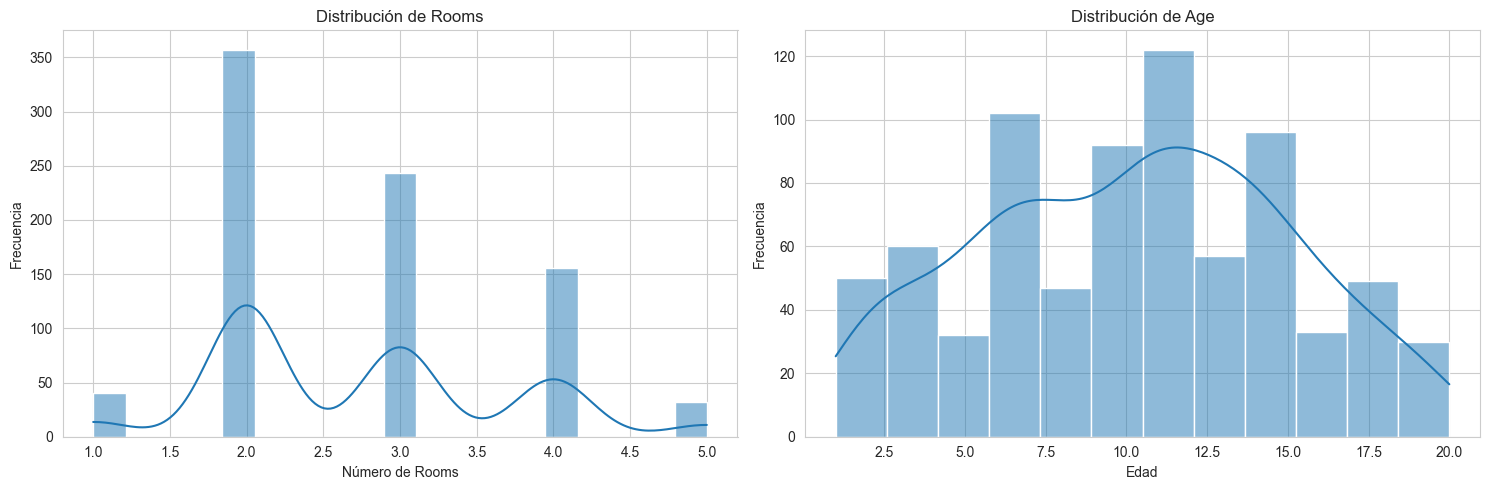

In [42]:
import seaborn as sns

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df['rooms'], kde=True, ax=axes[0])
axes[0].set_title('Distribución de Rooms')
axes[0].set_xlabel('Número de Rooms')
axes[0].set_ylabel('Frecuencia')

sns.histplot(df['age'], kde=True, ax=axes[1])
axes[1].set_title('Distribución de Age')
axes[1].set_xlabel('Edad')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Observamos que la media de ```roooms``` es ```2.737``` y que la media de ```age``` es ```10.212```. Podemos reemplazar en las muestras (filas) que tienen ```NaNs``` con la media. Esto es un proceso válido ya que al reemplazar los NaNs con la media, la variable conserva su escala original (no se generan valores fuera de rango ni se produce un sesgo), lo que ayuda a mantener la consistencia de la información que aporta esa variable.

Sin embargo, no estamos teniendo en cuenta que nuestros datos pueden estar agrupados en diferentes grupos. Momentareamente dejaré esta media insertada en los datos faltantes, pero cabe recalcar que está MAL, puesto que estamos agarrando el promedio de TODOS los grupos de datos que se presentan. A motivos de hacer este TP que siga con el enunciado, se realizaran las modificaciones en el inciso 4. 

Otra solución sería utilizar un modelo NO LINEAL para predecir estas features, solución que excede este TP.

In [43]:

features_to_impute = ['rooms', 'age']


for feature in features_to_impute:

    mean_value = df[feature].mean()
    
    df[feature] = df[feature].fillna(mean_value)
    
    print(f'Imputando en {feature} con la media: {mean_value}')
    

print(df.head())

Imputando en rooms con la media: 2.7379227053140096
Imputando en age con la media: 10.212987012987012
         area  is_house  has_pool   age  price        lat        lon  rooms
0   58.993405         1         0  18.0  546.0  40.679064 -74.007844    2.0
1  102.007494         0         0   9.0  759.0  40.712839 -73.967750    3.0
2   61.966301         0         0   7.0  464.0  40.669863 -74.029414    2.0
3  127.000000         1         1  16.0  251.0 -34.600437 -58.415266    4.0
4  128.020334         0         0   8.0  963.0  40.722322 -73.983229    4.0


Guardamos el dataframe en un CSV.

In [44]:
df.to_csv(r"../data/processed/casas_dev.csv", index=False)

## Punto 1.2 <a id="punto-1-2"></a>



<div style="padding: 10px; border-radius: 5px;">
    <p>
        Realice una serie de histogramas y diagramas de dispersión (scatterplots) para mostrar
        la relación entre las variables. Para esto, es útil el comando <code>pairplot</code>. 
        ¿Qué conclusiones puede extraer a simple vista acerca de las relaciones entre las variables? 
        Se permite la creación de gráficos adicionales que considere relevantes.
    </p>
</div>


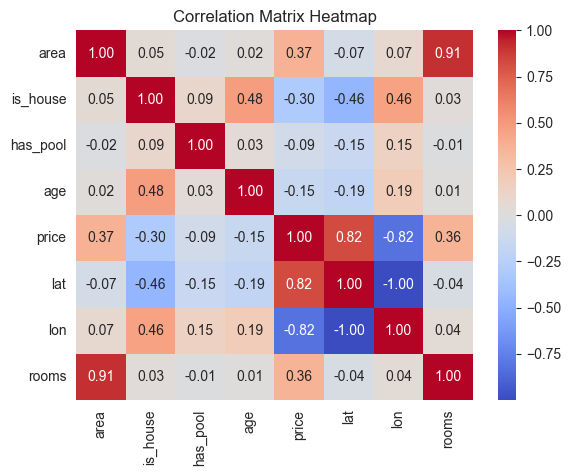

,area,is_house,has_pool,age,price,lat,lon,rooms
area,1.000000,0.047767,-0.020012,0.020607,0.371862,-0.071974,0.071787,0.907964
is_house,0.047767,1.000000,0.093175,0.482947,-0.298412,-0.459865,0.459664,0.029574
has_pool,-0.020012,0.093175,1.000000,0.033317,-0.088624,-0.146234,0.146399,-0.007955
age,0.020607,0.482947,0.033317,1.000000,-0.149007,-0.194795,0.194773,0.013094
price,0.371862,-0.298412,-0.088624,-0.149007,1.000000,0.822490,-0.822537,0.359635
lat,-0.071974,-0.459865,-0.146234,-0.194795,0.822490,1.000000,-0.999992,-0.040040
lon,0.071787,0.459664,0.146399,0.194773,-0.822537,-0.999992,1.000000,0.039892
rooms,0.907964,0.029574,-0.007955,0.013094,0.359635,-0.040040,0.039892,1.000000


In [45]:
import seaborn as sns 


# matriz de correlación
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

corr

Observamos que la variable **area** presenta una correlación muy alta de 0.91 con **rooms**, lo que es totalmente coherente, ya que a medida que aumenta la cantidad de habitaciones, la superficie total de la propiedad tiende a crecer. Además, la **latitud (lat)** muestra una fuerte correlación positiva de 0.82 con **price**, lo que sugiere que las propiedades ubicadas en zonas con mayor latitud tienden a tener precios más altos; en contraposición, la **longitud (lon)** tiene una correlación negativa de -0.82 con **price**, lo que indica que en las áreas donde la longitud es mayor, los precios son más bajos. Esto podría interpretarse como que existen zonas geográficas diferenciadas, donde la posición en el mapa influye significativamente en el valor de la propiedad. 

Por otro lado, se observa una correlación moderada de 0.48 entre **is_house** y **age**, lo que sugiere que las casas (frente a otros tipos de propiedades) tienden a ser más antiguas. Asimismo, **is_house** se relaciona moderadamente con las coordenadas: presenta una correlación de -0.46 con **lat** y de 0.46 con **lon**, lo que puede indicar que las casas se concentran en áreas geográficas específicas distintas a aquellas de otros inmuebles. 

Finalmente, resulta destacable la casi perfecta correlación negativa de -1.0 entre **lat** y **lon**, lo que implica que, dentro del rango de datos, a medida que aumenta la latitud, la longitud disminuye de forma casi lineal, reflejando probablemente una distribución geográfica particular de las propiedades. Estos patrones nos ayudan a entender que la ubicación y el tipo de inmueble son determinantes importantes en la configuración del precio y otras características de las viviendas en el dataset.

Podriamos clasificar las casas por zonas (clusters) en base a la latitud y longitud.

En el siguiente gráfico se observan en mayor detalle las relaciones entre las variables.

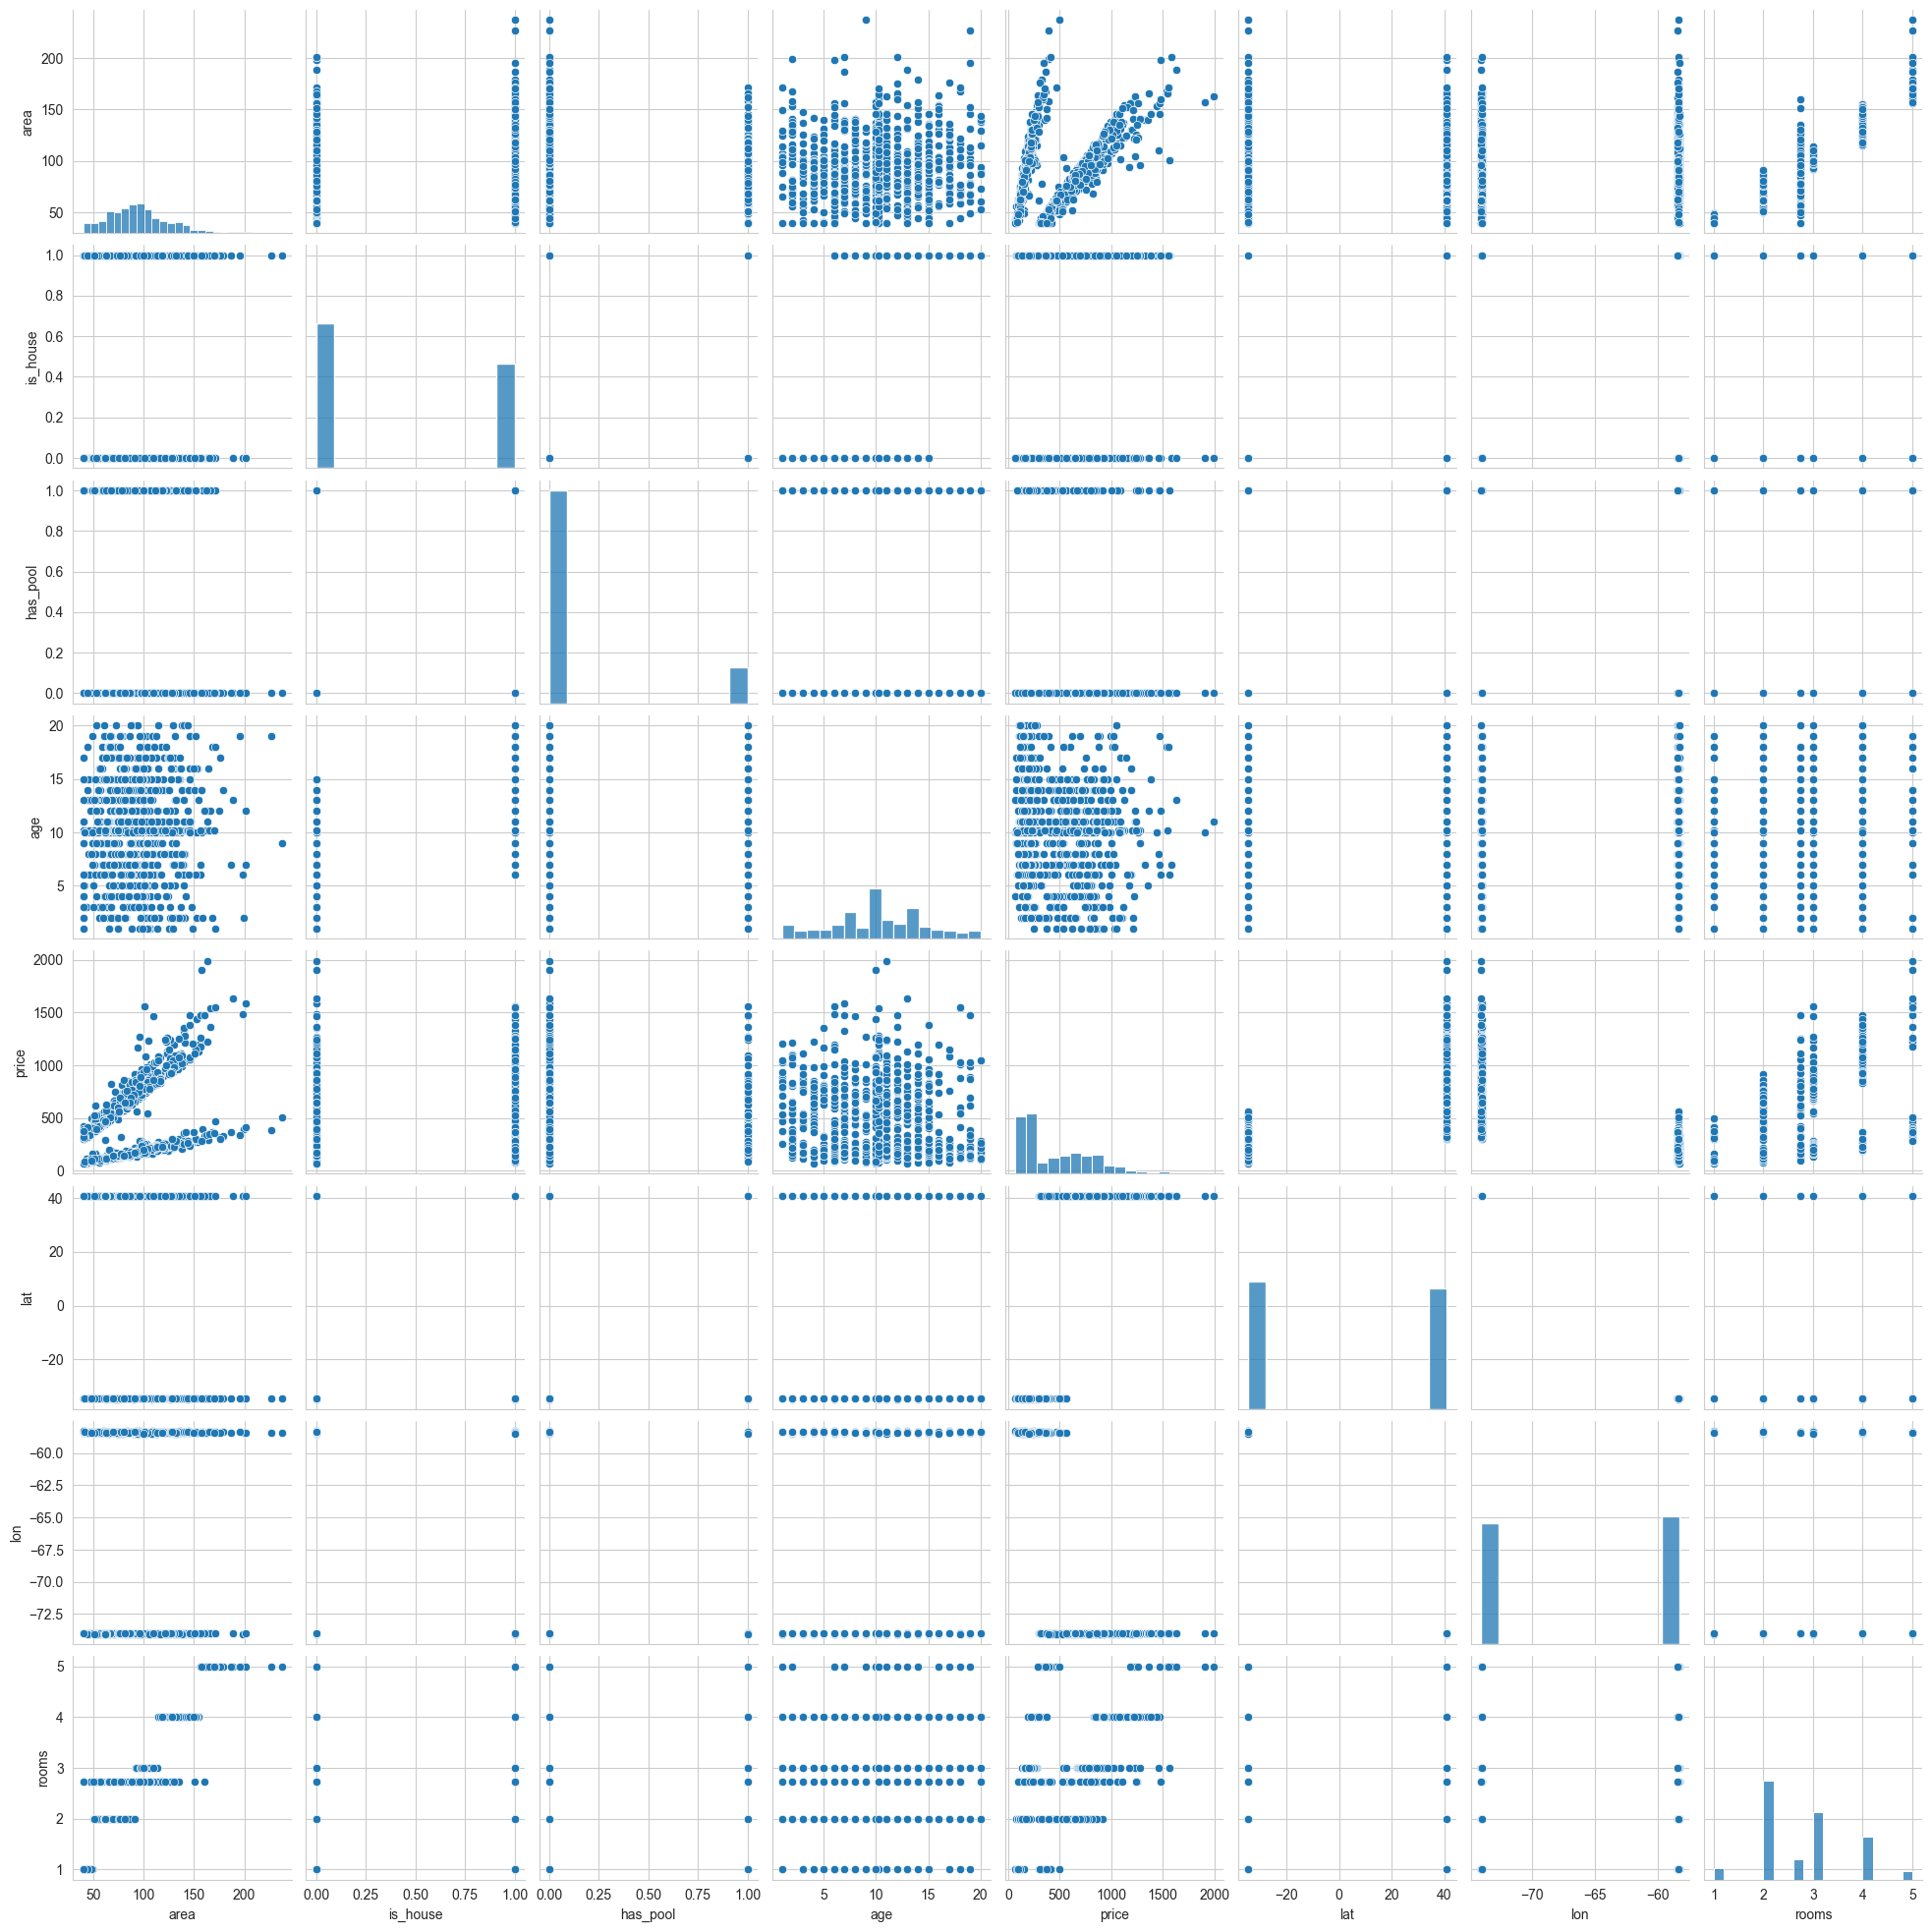

In [46]:
sns.pairplot(df)
plt.show()

Observamos en los gráficos de latitud y longitud como estan estrictamente correlacionados con una pendiente negativa. Parece haber 2 clusters en el mismo, caracteristica que explotaremos en el inciso 4. 

Por otro lado, en el grafico de area vs price notamos una correlacion positiva, lo que indicaria que a mayor area mayor es el precio, algo que es relativamente logico. Similarmente se nota este patron en el grafico de rooms vs price y rooms vs area.

Tambien notamos una correlacion positica entre latitud vs price, dandonos un indicador que ciertas zonas tienden a incrementar el valor de los inmuebles, mientras que la longitud vs price tiene una correlacion negativa, indicandonos

Por ultimo, notamos como, si el inmubele es una casa, tiende a tener mayor edad que aquellso que no



## Punto 1.3 <a id="punto-1-3"></a>


Divida el conjunto de desarrollo casas_dev.csv en un 80 % para entrenamiento (train)
y un 20 % para validación (validation). Estos conjuntos se utilizarán para entrenar y
validar los modelos que desarrollarán en las siguientes secciones. Se sugiere normalizar
los datos para lograr un mejora el condicionamiento numérico de los algortmos de
aprendizaje. Recuerde que si normaliza los datos, cuando haga una predicción deberá
invertir la normalización para volver a las escalas originales.

In [47]:
from models.regression.data import split_test_train_with_label

df = pd.read_csv(r"../data/processed/casas_dev.csv")

X = df.drop('price', axis=1)
y = df['price']

y = np.log(y)

X_train, X_test, y_train, y_test = split_test_train_with_label(X, y, test_size=0.2, random_state=12)


# Punto 2

### Todas las features (menos price)

#### Pseudo Inversa

In [48]:
from utils.model import train_and_evaluate_model
from models.regression.linear_regressor import LinearRegressor

results_linear_psinv_all = train_and_evaluate_model( # si no aplico log(y), el modelo es relativamente "malo"
    data_path=r"../data/processed/casas_dev.csv",
    target_column="price",
    test_size=0.20,
    random_state=12,
    transform_target=None,
    model_class=LinearRegressor,
    normalize_features=False,
    fit_params={'method': "pseudo_inverse"},
    metrics=['mse', 'r2', 'mae']
)

model_linear_psinv_all = results_linear_psinv_all["model"]



=== Model Evaluation (LinearRegressor) ===
MSE: 11630.160150
R2: 0.904712
MAE: 83.190651
Método: pseudo_inverse
Intercept: 3677.5350

Coeficientes:
------------------------------
area            | +4.9952
is_house        | +75.3474
has_pool        | +43.4141
age             | -3.4354
lat             | +19.9893
lon             | +56.3301
rooms           | -3.9214


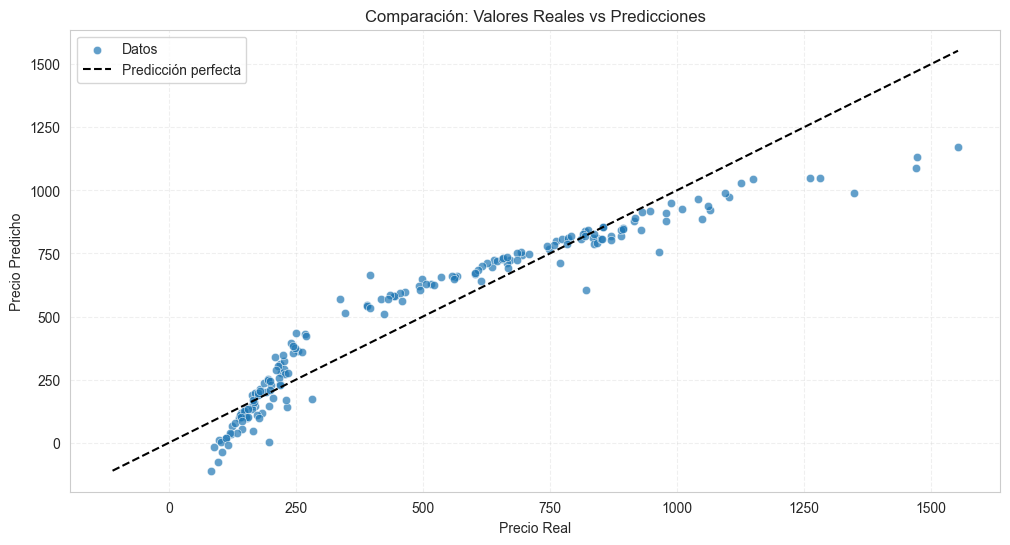

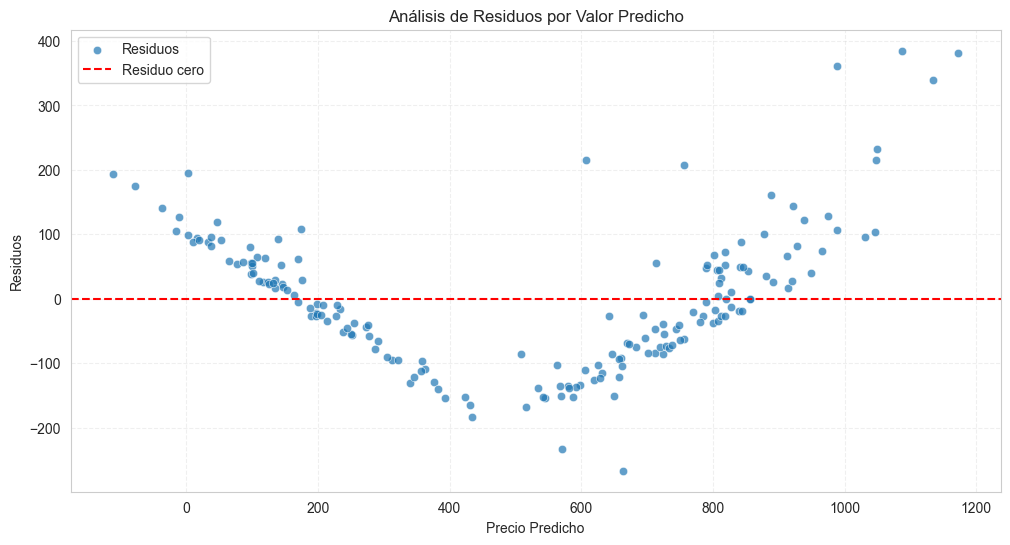

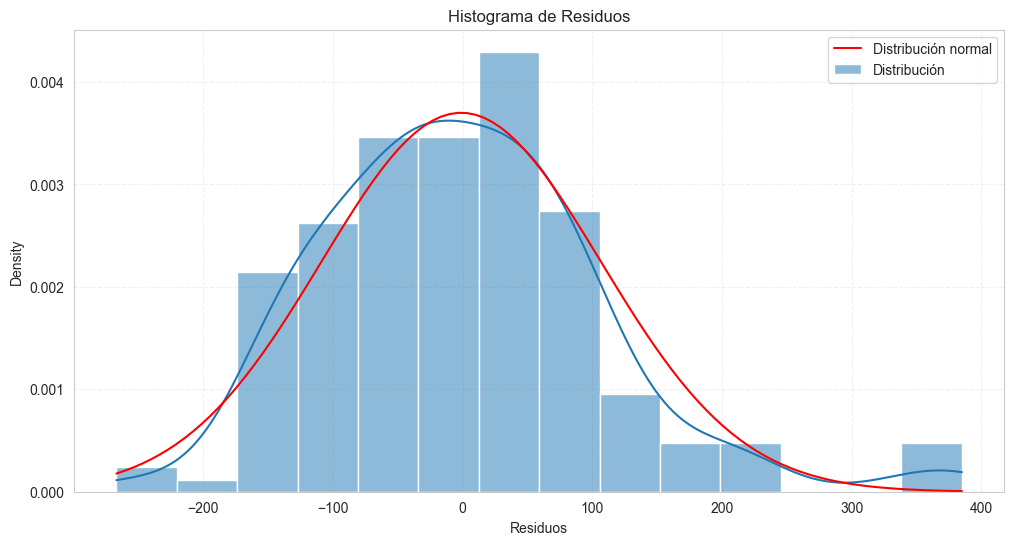

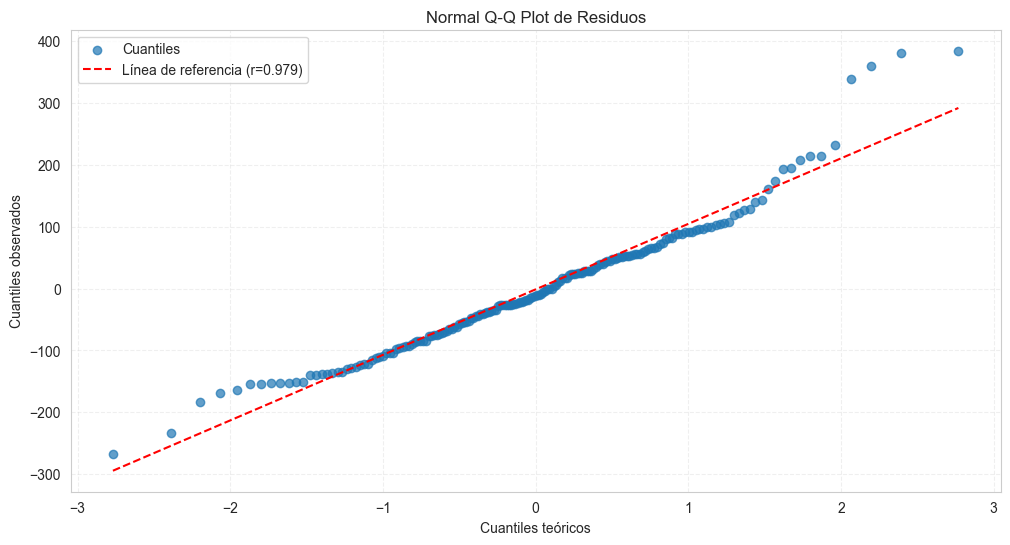

In [49]:
from utils.visuals import visualize_regression_results

custom_titles = {
    "scatter": "Comparación: Valores Reales vs Predicciones",
    "residuals": "Análisis de Residuos por Valor Predicho",
    "distribution": "Histograma de Residuos"
}


figures_linear_psinv_all = visualize_regression_results(
    results_linear_psinv_all['y_test'],
    results_linear_psinv_all['y_pred_test'],
    transform_func=None,
    fig_size=(12, 6),
    titles=custom_titles,
    show_figures=True
)



Los gráficos muestran en primer lugar, en el diagrama de valores predichos vs. residuos, que la varianza de los errores no se mantiene constante a lo largo de todo el rango de valores y se observa cierta curvatura empinada que sugiere una relación no capturada por el modelo o heterocedasticidad. Al mismo tiempo, el Q-Q plot (asumiendo una distribución normal) indica que, en general, los residuos se aproximan a la distribución normal, aunque se aprecian leves desvíos que podría deberse a la presencia de outliers. El histograma de residuos confirma que la mayoría se concentra cerca de cero pero existen valores atípicos que se extienden hacia la cola positiva. Conviene revisar si el modelo está capturando adecuadamente la forma funcional de las variables, por ejemplo, incluyendo términos polinómicos o interacciones en caso de relaciones no lineales. Ridge o Lasso pueden ayudar si hay multicolinealidad o sobreajuste, ya que estabilizan los coeficientes y reducen la varianza de las estimaciones, pero no resuelven de manera directa la heterocedasticidad. 

Estaría bueno hacer tests de heterocedasticidad.

#### Gradient Descent

In [50]:
from utils.model import train_and_evaluate_model
from models.regression.linear_regressor import LinearRegressor

results_gd_linear_all = train_and_evaluate_model(
    data_path=r"../data/processed/casas_dev.csv",
    target_column="price",
    test_size=0.20,
    random_state=12,
    model_class=LinearRegressor,
    transform_target=None,
    normalize_features=True,
    fit_params={'method': 'gradient_descent',
                "epochs": 1000,
                "learning_rate":0.01
                },
    metrics=['mse', 'r2', 'mae']
    )

model_gd_linear_all = results_gd_linear_all["model"]



=== Model Evaluation (LinearRegressor) ===
MSE: 11654.140146
R2: 0.904515
MAE: 83.430803
Método: gradient_descent
Intercept: 455.7167

Coeficientes:
------------------------------
area            | +139.8104
is_house        | +37.2665
has_pool        | +15.0462
age             | -14.7437
lat             | +155.9551
lon             | -155.8073
rooms           | +10.0213
Convergencia: Sí
Iteraciones: 1000/1000


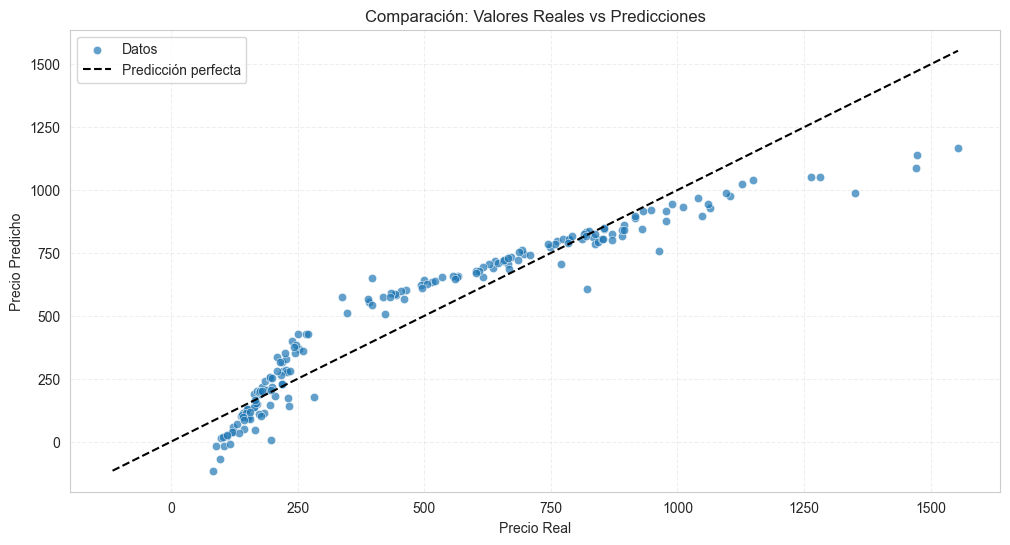

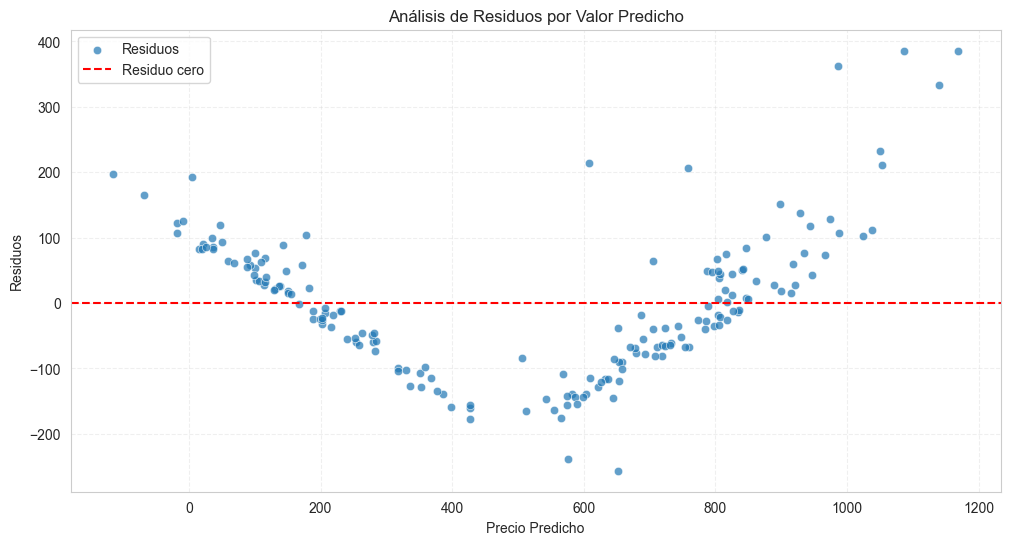

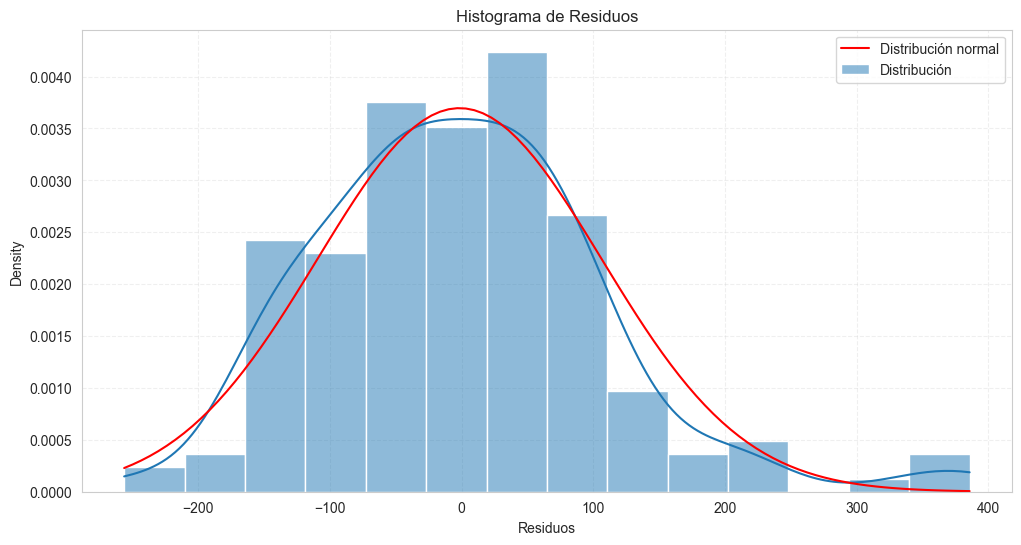

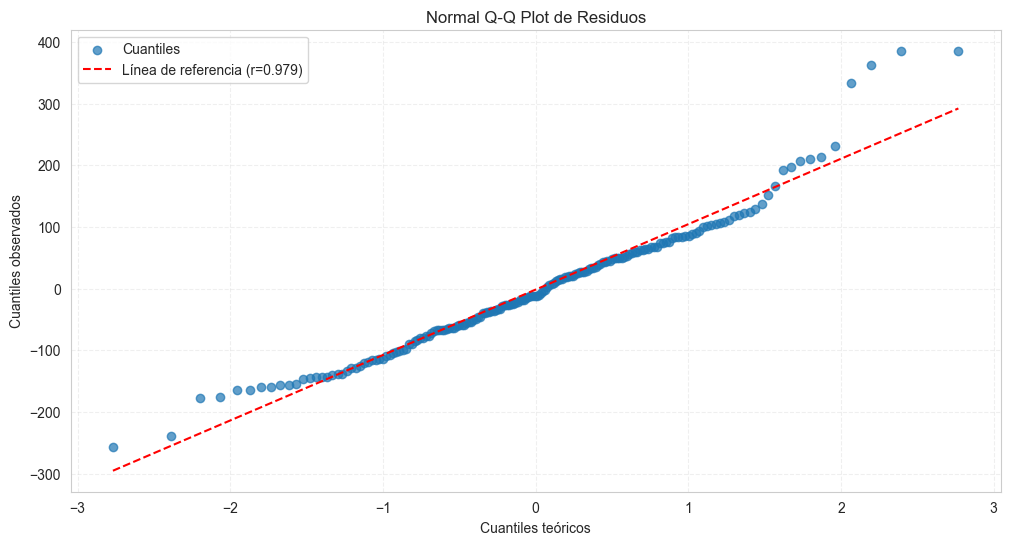

In [51]:
from utils.visuals import visualize_regression_results

custom_titles = {
    "scatter": "Comparación: Valores Reales vs Predicciones",
    "residuals": "Análisis de Residuos por Valor Predicho",
    "distribution": "Histograma de Residuos"
}

figures = visualize_regression_results(
    results_gd_linear_all['y_test'],
    results_gd_linear_all['y_pred_test'],
    transform_func=None,
    fig_size=(12, 6),
    titles=custom_titles,
    show_figures=True,
    fit_degree=1
)





### 1 feature


Pseudo Inversa

In [52]:
from utils.model import train_and_evaluate_model

results_linear_psinv_area = train_and_evaluate_model( 
    data_path=r"../data/processed/casas_dev.csv",
    target_column="price",
    test_size=0.20,
    random_state=12,
    feature_columns = ["area"],
    model_class=LinearRegressor,
    transform_target=None,
    normalize_features=False,
    fit_params={'method': 'pseudo_inverse'},
    metrics=['mse', 'r2', 'mae']
)

model_linear_psinv_area = results_linear_psinv_area["model"]


=== Model Evaluation (LinearRegressor) ===
MSE: 102728.297632
R2: 0.158327
MAE: 296.621040
Método: pseudo_inverse
Intercept: 75.5102

Coeficientes:
------------------------------
area            | +4.0167


Gradient descent


In [53]:
from utils.model import train_and_evaluate_model

results_gd_linear_area = train_and_evaluate_model( 
    data_path=r"../data/processed/casas_dev.csv",
    target_column="price",
    test_size=0.20,
    random_state=12,
    model_class=LinearRegressor,
    feature_columns = ["area"],
    normalize_features=True,
    fit_params={'method': 'gradient_descent',
                "epochs": 1000,
                "learning_rate":0.01
                },
    metrics=['mse', 'r2', 'mae'],
    verbose=True
)

model_gd_linear_area = results_gd_linear_area["model"]

results_gd_linear_area["normalization_params"]



=== Model Evaluation (LinearRegressor) ===
MSE: 102728.866581
R2: 0.158322
MAE: 296.621513
Método: gradient_descent
Intercept: 455.7119

Coeficientes:
------------------------------
area            | +123.4822
Convergencia: Sí
Iteraciones: 569/1000


{'mean': area    94.657096
 dtype: float64,
 'std': area    30.742739
 dtype: float64}

# Punto 3

## Punto 3.1

In [54]:
model_linear_psinv_area.print_coefficients()


Método: pseudo_inverse
Intercept: 75.5102

Coeficientes:
------------------------------
area            | +4.0167

MSE final: 104161.1444


### Punto 3.2

In [55]:
import pandas as pd
import numpy as np

df_amanda = pd.read_csv(r"../vivienda_Amanda.csv")

df_amanda.loc[df_amanda['area_units'] == 'sqft', 'area'] = df_amanda['area'] * 0.092903
df_amanda['area_units'] = 'm2'  

df_amanda = df_amanda.drop('area_units', axis=1)


print(f"Model features: {model_gd_linear_all.feature_names}")


# si normalice:
df_amanda = (df_amanda - X_train.mean()) / X_train.std()

y_pred = model_gd_linear_all.predict(df_amanda)

print(f"Predicted price a: {y_pred[0]:.2f}")


Model features: ['area', 'is_house', 'has_pool', 'age', 'lat', 'lon', 'rooms']
Predicted price a: 791.77


### Punto 3.3

3.3) En el dataset, ¿cuál es el valor promedio por metro cuadrado de una casa

peso de la regresión no normalizada

si lo normalice a cada putno lo desnormalizo

In [56]:
from utils.model import train_and_evaluate_model

df = pd.read_csv(r"../data/processed/casas_dev.csv")
df = df[df["is_house"] == 1]

results_area = train_and_evaluate_model( 
    df = df,
    target_column="price",
    test_size=0.20,
    random_state=12,
    feature_columns = ["area"],
    model_class=LinearRegressor,
    transform_target=None,
    normalize_features=False,
    fit_params={'method': 'pseudo_inverse'},
    metrics=['mse', 'r2', 'mae']
)

model_area = results_area["model"]


area_cof = model_area.get_coef_dict()["area"]

print(f"El valor promedio por metro cuadrado de una casa es: {area_cof:.2f}")


=== Model Evaluation (LinearRegressor) ===
MSE: 90594.214090
R2: 0.075942
MAE: 232.550763
Método: pseudo_inverse
Intercept: 0.4477

Coeficientes:
------------------------------
area            | +3.6400
El valor promedio por metro cuadrado de una casa es: 3.64


### Punto 3.4

Benito está evaluando la posibilidad de construir una pileta. ¿Cómo afectaría la construcción de una pileta al precio de su propiedad? Explique cómo llegó a este resultado.

In [57]:

df = pd.read_csv(r"../data/processed/casas_dev.csv")    

precios = df.groupby('has_pool')['price'].mean()
print(precios)


has_pool
0    478.831169
1    391.369231
Name: price, dtype: float64


In [58]:
from utils.model import train_and_evaluate_model

df_pool_house = pd.read_csv(r"../data/processed/casas_dev.csv")
df_pool_house = df_pool_house[df_pool_house["is_house"] == 1]

results_pool_house = train_and_evaluate_model( 
    df = df_pool_house,
    target_column="price",
    test_size=0.20,
    random_state=12,
    feature_columns = ["has_pool","area","age","rooms","lat","lon"],
    model_class=LinearRegressor,
    transform_target=None,
    normalize_features=False,
    fit_params={'method': 'pseudo_inverse'},
    metrics=['mse', 'r2', 'mae']
)

model_pool_house = results_pool_house["model"]


house_pool_cof = model_pool_house.get_coef_dict()["has_pool"]




=== Model Evaluation (LinearRegressor) ===
MSE: 12894.442548
R2: 0.868477
MAE: 71.337393
Método: pseudo_inverse
Intercept: 6246.4136

Coeficientes:
------------------------------
has_pool        | +13.8163
area            | +3.9181
age             | -2.5230
rooms           | -8.8413
lat             | +28.7934
lon             | +92.2951


In [59]:
from utils.model import train_and_evaluate_model
from utils.visuals import visualize_regression_results

df_pool_dept = pd.read_csv(r"../data/processed/casas_dev.csv")
df_pool_dept = df_pool_dept[df_pool_dept["is_house"] == 0]

results_pool_dept = train_and_evaluate_model( 
    df = df_pool_dept,
    target_column="price",
    test_size=0.20,
    random_state=12,
    feature_columns = ["has_pool","area","age","rooms","lat","lon"],
    model_class=LinearRegressor,
    transform_target=None,
    normalize_features=False,
    fit_params={'method': 'pseudo_inverse'},
    metrics=['mse', 'r2', 'mae']
)

model_pool_dept = results_pool_dept["model"]


dept_pool_cof = model_pool_dept.get_coef_dict()["has_pool"]





=== Model Evaluation (LinearRegressor) ===
MSE: 8787.337753
R2: 0.889084
MAE: 66.876828
Método: pseudo_inverse
Intercept: 9479.2122

Coeficientes:
------------------------------
has_pool        | +52.6778
area            | +5.9296
age             | -1.8944
rooms           | +6.8561
lat             | +38.0432
lon             | +146.5961



Impact of adding Pool for Departamentos:
- Absolute value added: $52.68
- Average property price: $554.10
- Percentage increase on average: 9.51%

Impact of adding Pool for Casas:
- Absolute value added: $13.82
- Average property price: $344.26
- Percentage increase on average: 4.01%


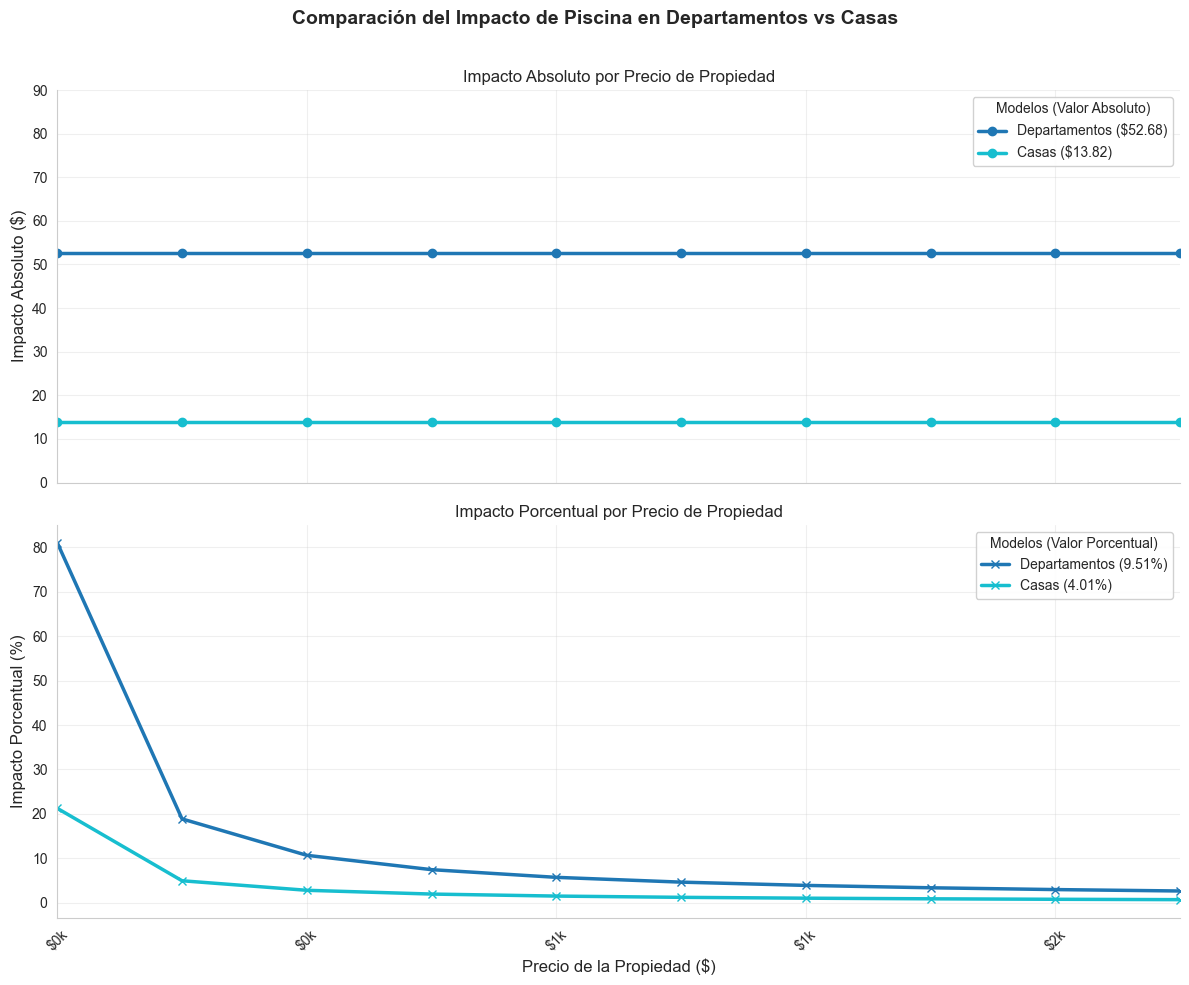

{'Departamentos': {'feature_name': 'has_pool',
  'display_name': 'Pool',
  'absolute_impact': 52.67777441775269,
  'average_price': 554.095602294455,
  'percentage_impact': 9.506982946556377},
 'Casas': {'feature_name': 'has_pool',
  'display_name': 'Pool',
  'absolute_impact': 13.81629938331185,
  'average_price': 344.2599469496021,
  'percentage_impact': 4.013333385348626}}

In [60]:
from utils.visuals import compare_feature_impact
# Example usage:
model_results = {
    "Departamentos": results_pool_dept,
    "Casas": results_pool_house
}

property_data = {
    "Departamentos": df_pool_dept,
    "Casas": df_pool_house
}

x_max = max(df_pool_dept['price'].max(), df_pool_house['price'].max())
x_min = min(df_pool_dept['price'].min(), df_pool_house['price'].min())
compare_feature_impact(
    model_results_dict=model_results,
    property_dfs=property_data,
    feature_name='has_pool',
    custom_title="Comparación del Impacto de Piscina en Departamentos vs Casas",
    x_lim=(x_min, x_max),
    y_lim=(0, 90)
)

# Punto 4

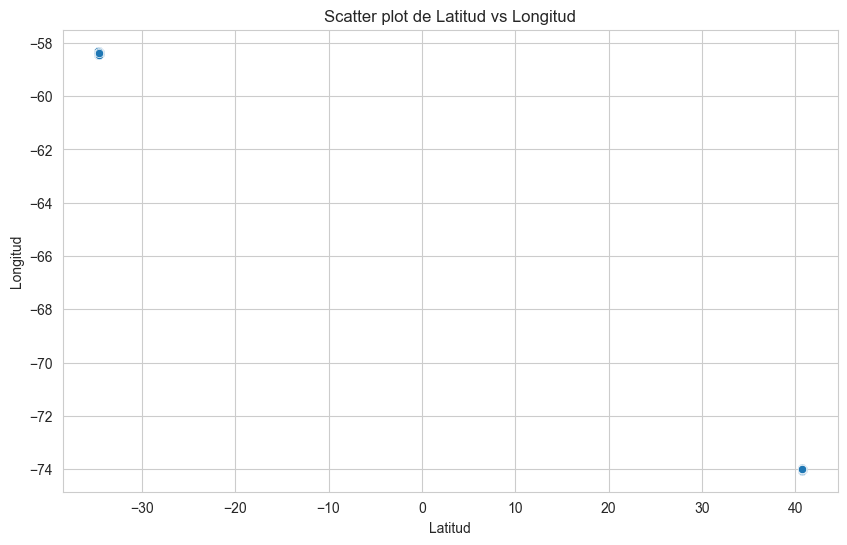

In [61]:
# scatter plot de 'lat' vs 'lon'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='lat', y='lon')
plt.title('Scatter plot de Latitud vs Longitud')
plt.xlabel('Latitud')
plt.ylabel('Longitud')
plt.show()

Index(['area', 'is_house', 'has_pool', 'age', 'price', 'lat', 'lon', 'rooms'], dtype='object')


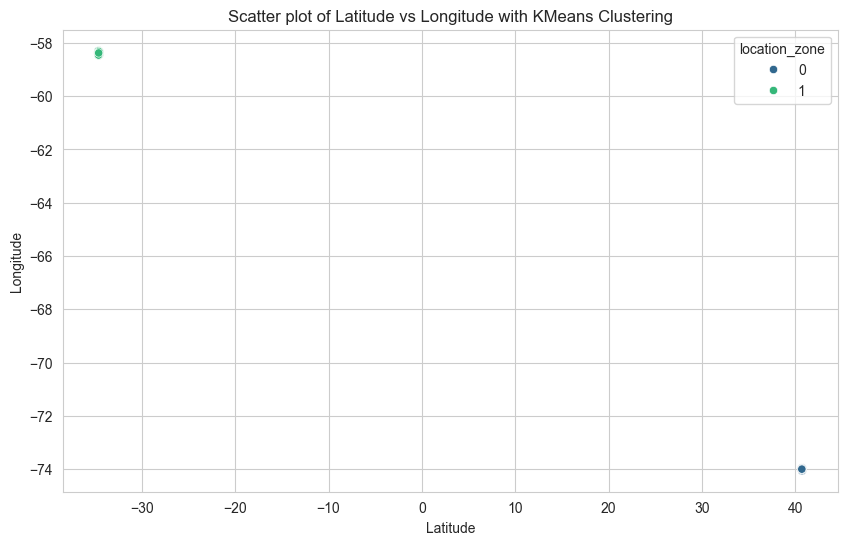

In [62]:
from models.clustering.kmeans import KMeans
df = pd.read_csv(r"../data/raw/casas_dev.csv")

df.isna().sum()


#insertar la media de age y rooms dependiendo de location zone (0 y 1)

df = pd.read_csv(r"../data/processed/casas_dev.csv")
print(df.columns)
# Step 2: Perform KMeans clustering on lat/lon
kmeans = KMeans(n_clusters=2)
kmeans.fit(df[['lat', 'lon']].to_numpy())

# Step 3: Add the cluster predictions to the original dataframe
df['location_zone'] = kmeans.predict(df[['lat', 'lon']].to_numpy())

# Step 4: Add the engineered features
df['area_per_room'] = df['area'] / df['rooms']
df['pool_house'] = df['has_pool'] * df['is_house']
df['house_area'] = df['area'] * df['is_house']



df_0 = df[df['location_zone'] == 0]
df_1 = df[df['location_zone'] == 1]


mean_age_0 = df_0['age'].mean()
mean_rooms_0 = df_0['rooms'].mean()

mean_age_1 = df_1['age'].mean()
mean_rooms_1 = df_1['rooms'].mean()

df.loc[df['location_zone'] == 0, 'age'] = df['age'].fillna(mean_age_0)
df.loc[df['location_zone'] == 0, 'rooms'] = df['rooms'].fillna(mean_rooms_0)

df.loc[df['location_zone'] == 1, 'age'] = df['age'].fillna(mean_age_1)
df.loc[df['location_zone'] == 1, 'rooms'] = df['rooms'].fillna(mean_rooms_1)

# guardar un df con solo latitud y longitud
df_pos = df[['lat', 'lon', 'location_zone']]
df = df.drop(['lat', 'lon'], axis=1)

# Step 6: Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pos, x='lat', y='lon', hue='location_zone', palette='viridis')
plt.title('Scatter plot of Latitude vs Longitude with KMeans Clustering')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()


# para los datos que son location_zone = 1

df.to_csv(r"../data/processed/casas_dev.csv", index=False)

In [63]:
import folium
import pandas as pd

# Cargar el dataset

print(df.columns)

# Definir el centro del mapa: puede ser la media de las latitudes y longitudes
map_center = [df_pos['lat'].mean(), df_pos['lon'].mean()]

# Crear el mapa centrado en map_center
m = folium.Map(location=map_center, zoom_start=12)

# Iterar sobre cada fila y agregar un marcador circular para cada ubicación
for idx, row in df_pos.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=2,                # tamaño del marcador
        color='blue',            # color del borde
        fill=True,
        fill_color='blue',       # color de relleno
        fill_opacity=0.6         # transparencia
    ).add_to(m)

# Guardar el mapa en un archivo HTML y mostrarlo (en Jupyter se muestra automáticamente)
m.save("all_locations_map.html")
m


Index(['area', 'is_house', 'has_pool', 'age', 'price', 'rooms',
       'location_zone', 'area_per_room', 'pool_house', 'house_area'],
      dtype='object')


In [64]:
df.sample(5, random_state=42)

,area,is_house,has_pool,age,price,rooms,location_zone,area_per_room,pool_house,house_area
70,81.011416,0,0,11.0,630.0,2.0,0,40.505708,0,0.000000
827,99.963628,0,0,7.0,772.0,3.0,0,33.321209,0,0.000000
231,137.000000,0,0,10.0,214.0,4.0,1,34.250000,0,0.000000
588,71.999825,1,1,10.0,751.0,2.0,0,35.999913,1,71.999825
39,154.000000,1,0,16.0,273.0,4.0,1,38.500000,0,154.000000


In [65]:
import numpy as np
from models.clustering.kmeans import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from models.regression.polinomial_regressor import PolinomialRegressor

# Step 1: Load the original data
df = pd.read_csv(r"../data/processed/casas_dev.csv")


# Step 7: Train the model on the engineered data
results_engineering = train_and_evaluate_model(
    df=df,  # Use the dataframe with all the engineered features
    target_column="price",
    test_size=0.20,
    random_state=12,
    model_class=LinearRegressor,
    transform_target=np.log,
    normalize_features=False,
    fit_params={'method': 'pseudo_inverse'},
    metrics=['mse', 'r2', 'mae']
)

model_engineering = results_engineering["model"]


=== Model Evaluation (LinearRegressor) ===
MSE: 0.012801
R2: 0.978757
MAE: 0.078409
Método: pseudo_inverse
Intercept: 5.6177

Coeficientes:
------------------------------
area            | +0.0108
is_house        | +0.2451
has_pool        | +0.1224
age             | -0.0080
rooms           | +0.0104
location_zone   | -1.4821
area_per_room   | -0.0007
pool_house      | -0.0151
house_area      | -0.0015


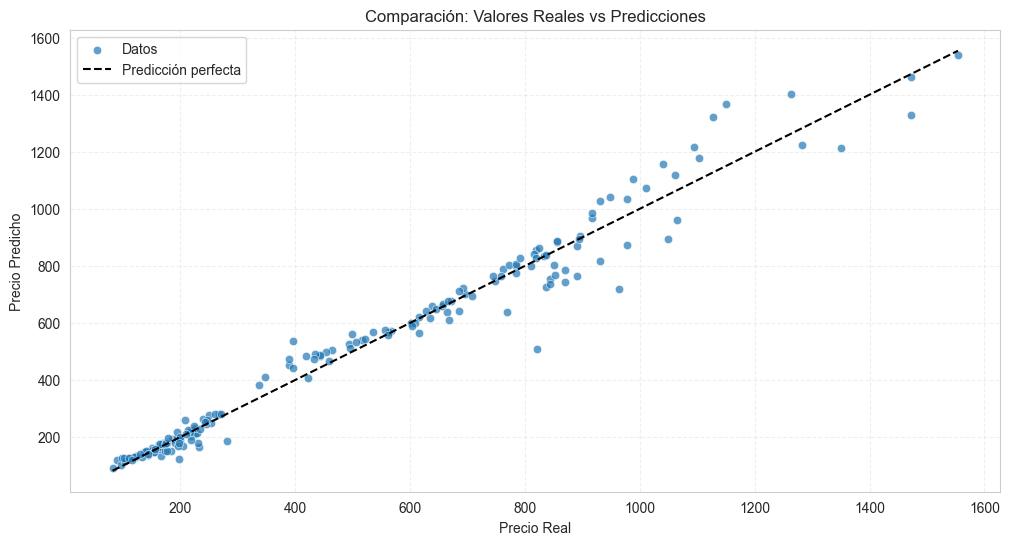

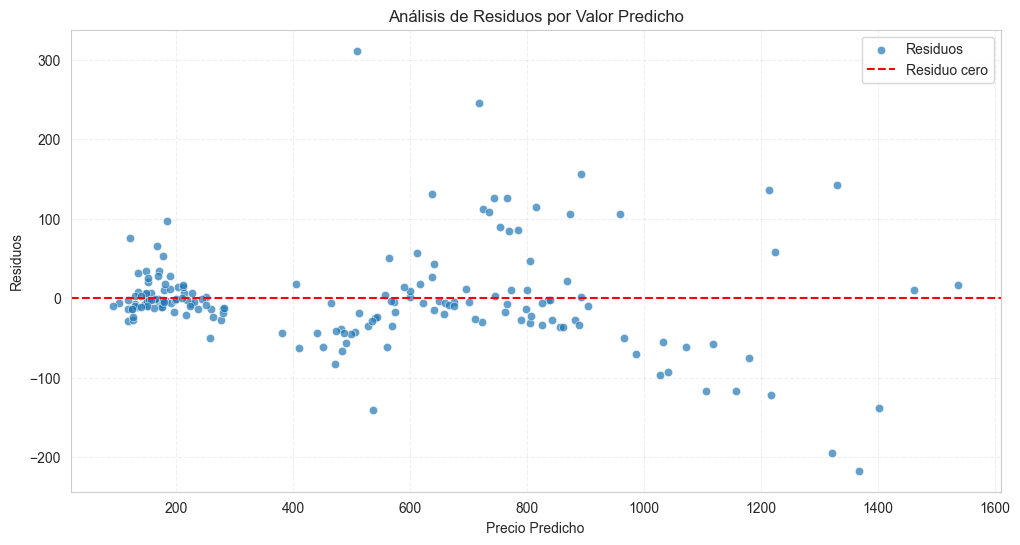

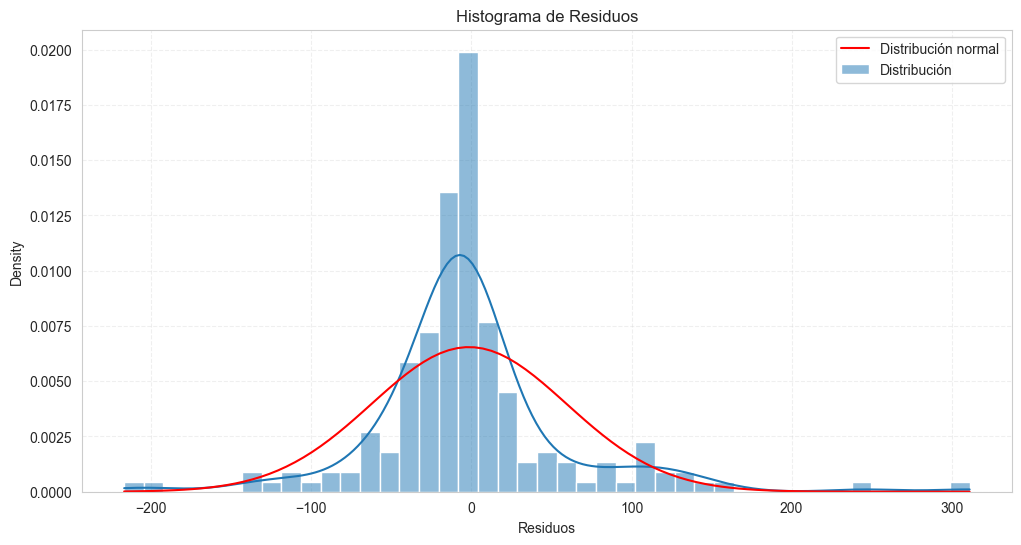

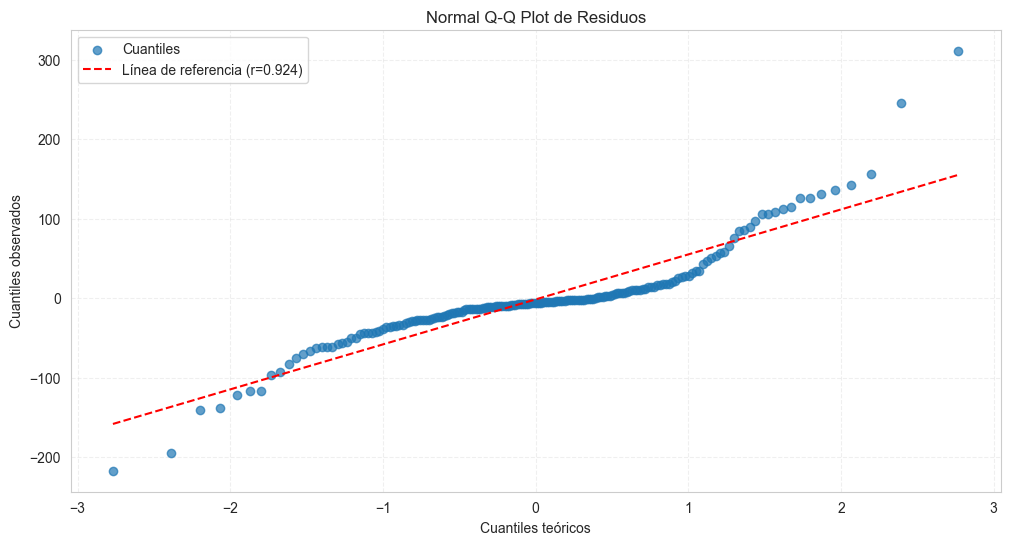

In [66]:
figures_engineering = visualize_regression_results(
    results_engineering['y_test'],
    results_engineering['y_pred_test'],
    transform_func=np.exp,
    fig_size=(12, 6),
    titles=custom_titles,
    show_figures=True,
    fit_degree=1
)

In [67]:
df_engineering2 = pd.read_csv(r"../data/processed/casas_dev.csv")


results_engineering2 = train_and_evaluate_model(
    df = df_engineering2,
    target_column="price",
    test_size=0.20,
    random_state=12,
    model_class=PolinomialRegressor.change_degree(2),
    transform_target=np.log,
    normalize_features=False,
    fit_params={'method': 'pseudo_inverse'},
    metrics=['mse', 'r2', 'mae']
)



=== Model Evaluation (PolinomialRegressor) ===
MSE: 0.010287
R2: 0.982928
MAE: 0.075401
Método: pseudo_inverse
Intercept: 5.6408

Coeficientes:
------------------------------
area            | +0.0259
is_house        | +0.1598
has_pool        | +0.0596
age             | -0.0115
rooms           | -0.1814
location_zone   | -0.7424
area_per_room   | -0.0171
pool_house      | -0.0097
house_area      | -0.0035
area^2          | -0.0001
is_house^2      | +0.1598
has_pool^2      | +0.0596
age^2           | +0.0002
rooms^2         | +0.0089
location_zone^2 | -0.7424
area_per_room^2 | +0.0001
pool_house^2    | -0.0097
house_area^2    | +0.0000


### Punto 4.3

In [68]:
import numpy as np
import pandas as pd

# Leer el DataFrame original
df_engineering3 = pd.read_csv(r"../data/processed/casas_dev.csv")
features = df_engineering3.columns.tolist()

# Número de nuevas features deseadas
num_features_needed = 300

# Generamos más pares de los necesarios para reducir iteraciones
num_attempts = int(num_features_needed * 1.5)

# Función auxiliar para generar pares únicos
def generar_pares(features, num_attempts):
    degrees = np.random.randint(1, 80, size=num_attempts)
    selected_features = np.random.choice(features, size=num_attempts)
    return {(f, int(d)) for f, d in zip(selected_features, degrees)}

# Generar los pares en bloque
pairs = generar_pares(features, num_attempts)
while len(pairs) < num_features_needed:
    # Si no alcanzamos, generamos más pares y actualizamos el set
    pairs.update(generar_pares(features, num_attempts))

# Tomar solo los primeros 300 pares
pairs = list(pairs)[:num_features_needed]

# Crear las nuevas features usando np.power para la potenciación vectorizada
new_features = {
    f"{feature}^{degree}": np.power(df_engineering3[feature], degree)
    for feature, degree in pairs
}

# Crear DataFrame con las nuevas features y concatenar
new_features_df = pd.DataFrame(new_features)
df_engineering3 = pd.concat([df_engineering3, new_features_df], axis=1)

# Mostrar resultados
print(f"Features originales: {len(features)}")
print(f"Nuevas features añadidas: {new_features_df.shape[1]}")
print(f"Total de features: {df_engineering3.shape[1]}")

df_engineering3.sample(5, random_state=42)



Features originales: 10
Nuevas features añadidas: 300
Total de features: 310


,area,is_house,has_pool,age,price,rooms,location_zone,area_per_room,pool_house,house_area,...,is_house^10,location_zone^36,house_area^54,house_area^63,area^58,location_zone^54,area^67,price^78,age^13,area_per_room^17
70,81.011416,0,0,11.0,630.0,2.0,0,40.505708,0,0.000000,...,0,0,0.000000e+00,0.000000e+00,4.962276e+110,0,7.457563e+127,2.231325e+218,3.452271e+13,2.127041e+27
827,99.963628,0,0,7.0,772.0,3.0,0,33.321209,0,0.000000,...,0,0,0.000000e+00,0.000000e+00,9.791214e+115,0,9.759210e+133,1.714547e+225,9.688901e+10,7.695783e+25
231,137.000000,0,0,10.0,214.0,4.0,1,34.250000,0,0.000000,...,0,1,0.000000e+00,0.000000e+00,8.507322e+123,1,1.446365e+143,5.919354e+181,1.000000e+13,1.228089e+26
588,71.999825,1,1,10.0,751.0,2.0,0,35.999913,1,71.999825,...,1,0,1.976504e+100,1.027734e+117,5.311578e+107,0,2.761891e+124,1.994872e+224,1.000000e+13,2.865000e+26
39,154.000000,1,0,16.0,273.0,4.0,1,38.500000,0,154.000000,...,1,1,1.336962e+118,6.513365e+137,7.519722e+126,1,3.663433e+146,1.048785e+190,4.503600e+15,8.970825e+26


In [72]:
from utils.model import train_and_evaluate_model
from models.regression.polinomial_regressor import PolinomialRegressor

results_engineering3 = train_and_evaluate_model(
    df = df_engineering3,
    target_column="price",
    test_size=0.20,
    random_state=12,
    model_class=LinearRegressor,
    transform_target=np.log,
    normalize_features=False,
    fit_params={'method': 'pseudo_inverse'},
    metrics=['mse', 'r2', 'mae']
)

model_engineering3 = results_engineering3["model"]



=== Model Evaluation (LinearRegressor) ===
MSE: 0.342565
R2: -17.147285
MAE: 0.568936
Método: pseudo_inverse
Intercept: -0.0000

Coeficientes:
------------------------------
area            | +0.0000
is_house        | +0.0000
has_pool        | +0.0000
age             | +0.0000
rooms           | +0.0000
location_zone   | +0.0000
area_per_room   | +0.0000
pool_house      | +0.0000
house_area      | +0.0000
area^61         | +0.0000
rooms^1         | +0.0000
age^74          | +0.0000
price^13        | +0.0000
house_area^25   | +0.0000
location_zone^16 | +0.0000
has_pool^18     | +0.0000
area^38         | +0.0000
price^49        | +0.0000
is_house^75     | +0.0000
has_pool^45     | +0.0000
rooms^5         | +0.0000
age^78          | +0.0000
rooms^23        | +0.0000
pool_house^12   | +0.0000
house_area^2    | +0.0000
house_area^11   | +0.0000
area^6          | +0.0000
location_zone^2 | +0.0000
has_pool^22     | +0.0000
price^35        | +0.0000
is_house^61     | +0.0000
price^44        | 

# Punto 5


# FINAL

In [ ]:
df = pd.read_csv(r"../data/raw/casas_test.csv")

df.isna().sum()

area           0
area_units     0
is_house       0
has_pool       0
age           16
price          0
lat            0
lon            0
rooms          4
dtype: int64

In [ ]:
# Load the test data
df = pd.read_csv(r"../data/raw/casas_test.csv")

# Apply the same preprocessing steps
df.loc[df['area_units'] == 'sqft', 'area'] = df['area'] * 0.092903
df.loc[df['area_units'] == 'sqft', 'area_units'] = 'm2'
df['location_zone'] = kmeans.predict(df[['lat', 'lon']].to_numpy())

df['area_per_room'] = df['area'] / df['rooms']
df['pool_house'] = df['has_pool'] * df['is_house']

df = df.drop('area_units', axis=1)

# Save the processed test data
df.to_csv(r"../data/processed/casas_test.csv", index=False)


In [ ]:
#insertar la media de age y rooms dependiendo de location zone (0 y 1)
df = pd.read_csv(r"../data/processed/casas_test.csv")

df_0 = df[df['location_zone'] == 0]
df_1 = df[df['location_zone'] == 1]


mean_age_0 = df_0['age'].mean()
mean_rooms_0 = df_0['rooms'].mean()

mean_age_1 = df_1['age'].mean()
mean_rooms_1 = df_1['rooms'].mean()

df.loc[df['location_zone'] == 0, 'age'] = df['age'].fillna(mean_age_0)
df.loc[df['location_zone'] == 0, 'rooms'] = df['rooms'].fillna(mean_rooms_0)

df.loc[df['location_zone'] == 1, 'age'] = df['age'].fillna(mean_age_1)
df.loc[df['location_zone'] == 1, 'rooms'] = df['rooms'].fillna(mean_rooms_1)

df = df.drop(['lat', 'lon'], axis=1)

df.to_csv(r"../data/processed/casas_test.csv", index=False)

In [ ]:
X_test = df.drop('price', axis=1)


# Get the target variable
y_test = df['price']

# Apply log transformation to match training
y_test = np.log(y_test)

# Make predictions
y_pred_test = model_engineering.predict(X_test)
y_pred_test = np.exp(y_pred_test)  # Inverse transform predictions

# Calculate metrics
r2 = model_engineering.r2_score(X_test, y_test)
print("R² Score:", r2)

ValueError: Número incorrecto de características. Esperado: 10, Recibido: 9